In [8]:
! pip install jupyter notebook jupyter_contrib_nbextensions

  Running setup.py bdist_wheel for jupyter-nbextensions-configurator: started
  Running setup.py bdist_wheel for jupyter-nbextensions-configurator: finished with status 'done'
  Stored in directory: C:\Users\salee\AppData\Local\pip\Cache\wheels\15\df\fe\2a74fe34709e7fdc5ae153a768675d9fda93cc7d5133ed1fb0
  Running setup.py bdist_wheel for jupyter-latex-envs: started
  Running setup.py bdist_wheel for jupyter-latex-envs: finished with status 'done'
  Stored in directory: C:\Users\salee\AppData\Local\pip\Cache\wheels\0d\71\2a\164491997299b9f2479a251e254323fe35d946779e18f27956
Successfully built jupyter-nbextensions-configurator jupyter-latex-envs


In [12]:
!pip install https://download.pytorch.org/whl/cpu/torch-1.0.1-cp37-cp37m-win_amd64.whl
!pip install torchvision

  Using cached https://files.pythonhosted.org/packages/fb/01/03fd7e503c16b3dc262483e5555ad40974ab5da8b9879e164b56c1f4ef6f/torchvision-0.2.2.post3-py2.py3-none-any.whl


In [5]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from fastai.imports import *
from fastai.tabular import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
!pip install pandas-summary

  Using cached https://files.pythonhosted.org/packages/6b/00/f7b4d7fd901db9a79d63e88000bd1e12efba4f5fb52608f906d7fea2b18f/pandas_summary-0.0.6-py2.py3-none-any.whl


In [6]:
import pandas as pd

df_raw = pd.read_csv('Train.csv', low_memory=False, 
                     parse_dates=["saledate"])

In [7]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
import numpy as np

df_raw.SalePrice = np.log(df_raw.SalePrice)

In [23]:
import re
def add_datepart(df, fldname):
    fld = df[fldname]
    
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 
            'Dayofyear', 'Is_month_end', 'Is_month_start', 
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 
            'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    df.drop(fldname, axis=1, inplace=True)



add_datepart(df_raw, 'saledate')

In [42]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype

def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

train_cats(df_raw)



In [43]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

In [45]:

df_raw.UsageBand = df_raw.UsageBand.cat.codes


In [48]:
!pip install -U feather-format

  Using cached https://files.pythonhosted.org/packages/08/55/940b97cc6f19a19f5dab9efef2f68a0ce43a7632f858b272391f0b851a7e/feather-format-0.4.0.tar.gz
  Running setup.py bdist_wheel for feather-format: started
  Running setup.py bdist_wheel for feather-format: finished with status 'done'
  Stored in directory: C:\Users\salee\AppData\Local\pip\Cache\wheels\85\7d\12\2dfa5c0195f921ac935f5e8f27deada74972edc0ae9988a9c1
Successfully built feather-format


In [49]:
import os

os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('bulldozers-raw')

In [72]:
import feather
df_raw=feather.read_dataframe('bulldozers-raw')

In [73]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res


def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
            
    return na_dict

def numericalize(df, col, name, max_n_cat):
    
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1


def get_sample(df,n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()


In [74]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [83]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

C:\Users\salee\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9831046847949627

In [130]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

In [87]:
import math

def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [88]:
m = RandomForestRegressor(n_jobs=-1)
%time 
m.fit(X_train, y_train)
print_score(m)

C:\Users\salee\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Wall time: 26.1 s
[0.09035860527840885, 0.24742189505282, 0.982936274203036, 0.8906738053288829]


In [91]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [92]:

m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

C:\Users\salee\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Wall time: 1.62 s
[0.11252724495919954, 0.3819483505167777, 0.972445507035191, 0.7394702926533994]


In [93]:

m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5277546834093337, 0.5811230225656325, 0.39390424277183544, 0.39690720963380655]


In [104]:
!pip install graphviz

In [118]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

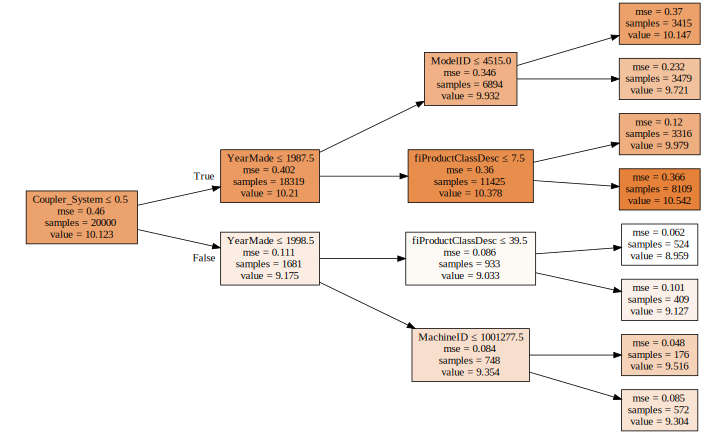

In [119]:
from sklearn.tree import export_graphviz
%matplotlib inline
import graphviz

import IPython

def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))


draw_tree(m.estimators_[0], df_trn, precision=3)

In [120]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[6.879800455918813e-17, 0.468532135570605, 1.0, 0.6079632853573544]


In [131]:

m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

C:\Users\salee\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.0903675835892189, 0.2473032298338731, 0.9829328830253017, 0.890778647350266]


In [132]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([9.21034037, 9.10497986, 9.15904708, 8.98719682, 9.10497986,
        9.10497986, 8.98719682, 9.10497986, 9.10497986, 9.39266193]),
 9.126134230125068,
 9.104979856318357)

In [133]:
preds.shape

(10, 12000)

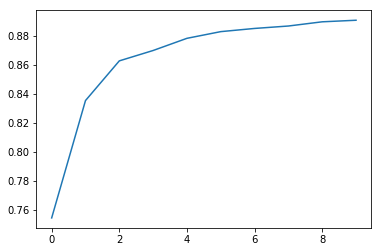

In [134]:
import matplotlib.pyplot as plt
from sklearn import metrics

plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

In [135]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07855119735159848, 0.2367427292224801, 0.9871044329233531, 0.899907560575077, 0.9081326403717247]


In [136]:

df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [139]:
from sklearn.ensemble import forest

def set_rf_samples(n):
    forest._generate_sample_indices = (lambda rs, n_samples:
    forest.check_random_state(rs).randint(0, n_samples, n))

set_rf_samples(20000)

In [140]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

C:\Users\salee\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Wall time: 6.3 s
[0.24103067512105847, 0.2831986090407778, 0.8785830104847686, 0.8567712486326258, 0.8660572855775885]


In [142]:
def reset_rf_samples():
    forest._generate_sample_indices = (lambda rs, n_samples:
    forest.check_random_state(rs).randint(0, n_samples, n_samples))
reset_rf_samples()

In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)